In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.esdr_ph - self.v_s_ph
        mean_adv = tf.reduce_mean(advantage)
        stddev_adv = mean_adv*mean_adv - tf.reduce_mean(advantage*advantage)
        self.adv_normalized = (advantage - mean_adv)/stddev_adv
        
        # Shared-parameter policy and value network
        W1p = tf.get_variable("w1p", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1p = tf.get_variable("b1p", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2p_means = tf.get_variable("w2pmeans", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        W2p_stdevs = tf.get_variable("w2pstdevs", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        b2p_means = tf.get_variable("b2pmeans", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        b2p_stdevs = tf.get_variable("b2pstdevs", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1p = tf.nn.relu(tf.matmul(self.observations_ph, W1p) + b1p)
        # this will need to be changed to accommodate the range and character of action values
        l2p_means = tf.matmul(l1p, W2p_means) + b2p_means
        # Trying to start with a large standard deviation to encourage exploration early on.
        l2p_stdevs = tf.matmul(l1p, W2p_stdevs) + b2p_stdevs + 1.25
        l2_policy_means = 2*tf.nn.tanh(l2p_means)
        l2_policy_stdevs = tf.math.maximum(tf.math.minimum(tf.nn.softplus(l2p_stdevs), 10), 0.01)
        
        W1v = tf.get_variable("w1v", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1v = tf.get_variable("b1v", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.random_normal(stddev=0.01)) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1v = tf.nn.relu(tf.matmul(self.observations_ph, W1v) + b1v)
        l2v = tf.matmul(l1v, W2v) + b2v
        
        self.reinforce_loss = tf.reduce_mean(
            (self.esdr_ph)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8))
            - 0.01*tf.log(l2_policy_stdevs)
        )
        self.reinforce_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.reinforce_loss)
        
        self.actor_critic_loss = tf.reduce_mean(
            (advantage)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8))
        ) + tf.reduce_mean(tf.square(l2v - self.esdr_ph) - 0.01*tf.log(l2_policy_stdevs)) 
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        grads_and_vars = optimizer.compute_gradients(self.actor_critic_loss)
        capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        self.actor_critic_optimizer = optimizer.apply_gradients(capped_grads)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        
        advantage_feeds = {
            self.observations_ph: states
        }
        #print("shape of discounted rewards:", discounted_rewards.shape)
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        #print(v_predictions.shape)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions
        }
        
        optimize_fetches = [
            #self.reinforce_loss,
            self.actor_critic_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            #self.reinforce_optimizer
            self.actor_critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _ = self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions

In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print(len(states), len(actions), len(rewards))
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    actions = np.array(actions)
    states = np.array(states)
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    
    return actions_shuffled, states_shuffled, discounted_rewards_shuffled

In [4]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=50):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ep_action_t = np.random.normal(loc=agent.predict(ep_state_t)[0][0], scale=agent.predict(ep_state_t)[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
    return states, actions, rewards

In [5]:
def renderAgent(env, agent):
    state_t = env.reset()
    rewards = 0
    actions = []
    while i < 1000:
        action_t = np.random.normal(loc=agent.predict(state_t)[0][0], scale=agent.predict(state_t)[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions

In [6]:
#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


Acrobot-v1
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Ant-v2
Assault-ram-v0
Assault-ram-v4
Assault-ramDeterministic-v0
Assault-ramDeterministic-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
Assault-v0
Assault-v4
AssaultDeterministic-v0
AssaultDeterministic-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Asterix-ra

In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())

/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0
average reward:  -1277.8823355680327 stdevs: 1.5047492 losses: 208596.42
1
average reward:  -1235.4894316383638 stdevs: 1.492908 losses: 260303.86
2
average reward:  -1240.1721873383065 stdevs: 1.4519287 losses: 110856.25
3
average reward:  -1270.0798123771854 stdevs: 1.425009 losses: 69850.6
4
average reward:  -1140.8360824447416 stdevs: 1.3754289 losses: 88863.086
5
average reward:  -1260.1860759028118 stdevs: 1.379031 losses: 215805.67
6
average reward:  -1203.5213833514294 stdevs: 1.2461627 losses: 113640.9
7
average reward:  -1214.0444297004524 stdevs: 1.3062395 losses: 253649.77
8
average reward:  -1192.3442230730986 stdevs: 1.1619707 losses: 75005.06
9
average reward:  -1224.2958198362933 stdevs: 1.1163131 losses: 159064.38
Rewards from rendering: -1032.835890960416


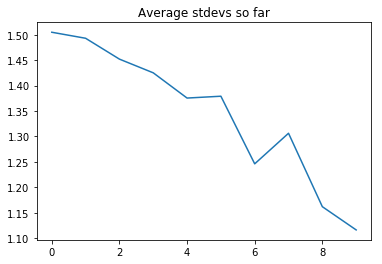

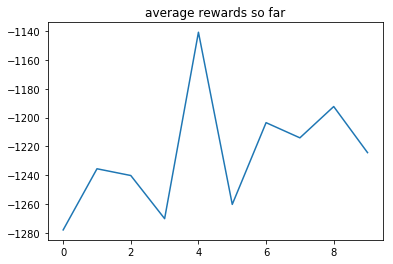

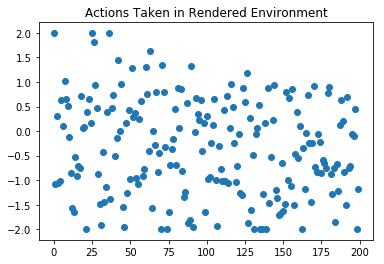

10
average reward:  -1168.5742017601385 stdevs: 1.0449637 losses: 157147.2
11
average reward:  -1287.3654438219312 stdevs: 0.95065385 losses: 141473.1
12
average reward:  -1252.9764441880175 stdevs: 0.69849455 losses: 144884.16
13
average reward:  -1274.5999615047833 stdevs: 0.7905533 losses: 127772.03
14
average reward:  -1323.3933383776803 stdevs: 0.71846694 losses: 129323.82
15
average reward:  -1352.5904717206545 stdevs: 0.53833413 losses: 121631.43
16
average reward:  -1365.1935839346752 stdevs: 0.66076124 losses: 184472.62
17
average reward:  -1375.369204249393 stdevs: 0.32378784 losses: 164919.2
18
average reward:  -1390.9800763043354 stdevs: 0.5155183 losses: 162700.3
19
average reward:  -1441.3942719193167 stdevs: 0.49409652 losses: 199706.06
Rewards from rendering: -1355.3892465341019


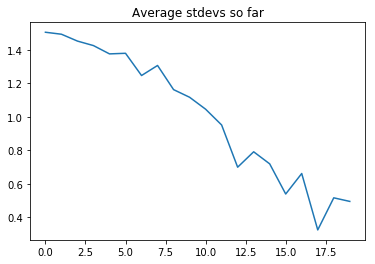

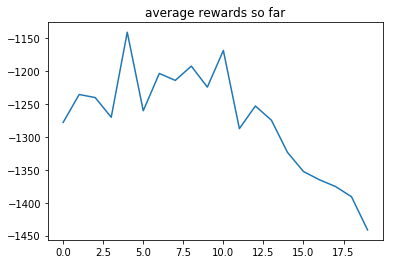

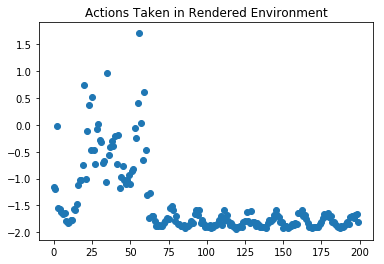

20
average reward:  -1440.583376206252 stdevs: 0.10062437 losses: 231281.11
21
average reward:  -1493.412758879478 stdevs: 0.048069313 losses: 236366.9
22
average reward:  -1509.5787683619328 stdevs: 0.07554074 losses: 244693.3
23
average reward:  -1499.0611107979869 stdevs: 0.02169404 losses: 261131.16
24
average reward:  -1535.9658859809074 stdevs: 0.028050676 losses: 261694.62
25
average reward:  -1523.1863593459943 stdevs: 0.10070153 losses: 243918.44
26
average reward:  -1507.8798366078743 stdevs: 0.017250273 losses: 261229.1
27
average reward:  -1536.8139942020734 stdevs: 0.05026177 losses: 249667.9
28
average reward:  -1530.4173083979497 stdevs: 0.07907136 losses: 243178.23
29
average reward:  -1563.5136635766407 stdevs: 0.066987075 losses: 218784.39
Rewards from rendering: -1568.922153633993


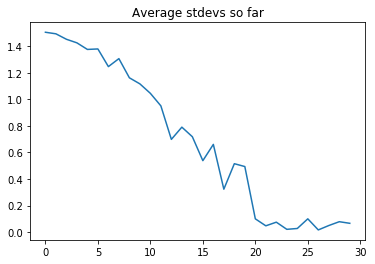

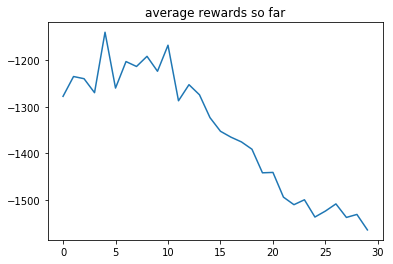

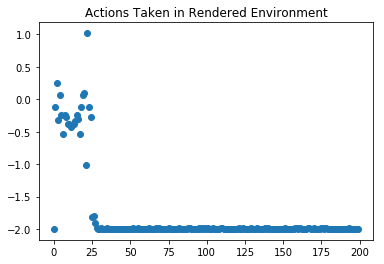

30
average reward:  -1563.0861614044534 stdevs: 0.068838514 losses: 235405.97
31
average reward:  -1558.6490957709057 stdevs: 0.054069027 losses: 215791.38
32
average reward:  -1551.3244477678202 stdevs: 0.013339298 losses: 256926.86
33
average reward:  -1519.1557869095247 stdevs: 0.029290397 losses: 229353.97
34
average reward:  -1515.2265804198003 stdevs: 0.023764798 losses: 14355.219
35
average reward:  -1562.4410406399165 stdevs: 0.038613252 losses: 210812.06
36
average reward:  -1564.2950492274833 stdevs: 0.014483984 losses: 252566.61
37
average reward:  -1589.796889354997 stdevs: 0.011626912 losses: 249334.1
38
average reward:  -1593.962666936015 stdevs: 0.01110775 losses: 246321.8
39
average reward:  -1585.3600003899905 stdevs: 0.015937198 losses: 251365.56
Rewards from rendering: -1639.0252718568518


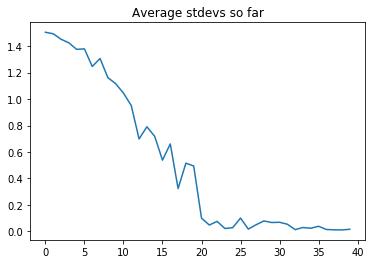

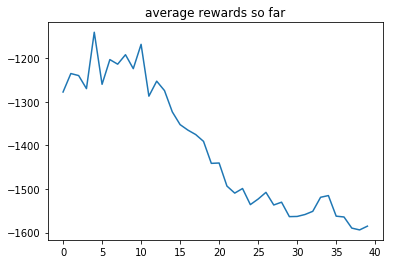

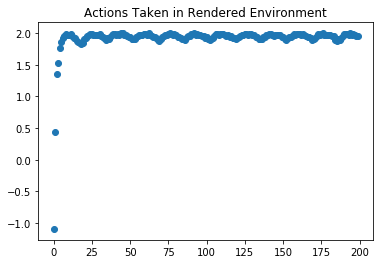

40
average reward:  -1604.72972861046 stdevs: 0.01302328 losses: 261987.88
41
average reward:  -1606.9894230714317 stdevs: 0.011681064 losses: 261066.42
42
average reward:  -1600.4861119415054 stdevs: 0.012869147 losses: 234922.06
43
average reward:  -1602.460976028967 stdevs: 0.010729394 losses: 260312.69
44
average reward:  -1591.7343588666854 stdevs: 0.010188771 losses: 243613.08
45
average reward:  -1606.9036843509678 stdevs: 0.010712702 losses: 260808.95
46
average reward:  -1606.8487240426068 stdevs: 0.011243645 losses: 251800.23
47
average reward:  -1610.6849401386892 stdevs: 0.010445237 losses: 233923.17
48
average reward:  -1603.9137641267391 stdevs: 0.01013634 losses: 251683.94
49
average reward:  -1604.8296080426353 stdevs: 0.010449103 losses: 244112.53
Rewards from rendering: -1563.550453635224


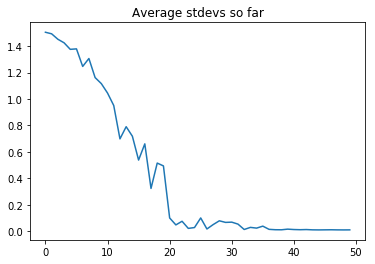

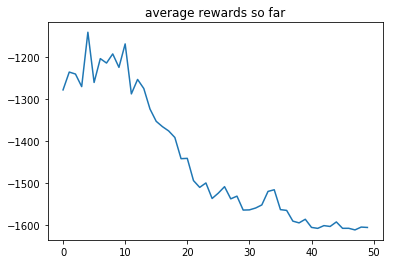

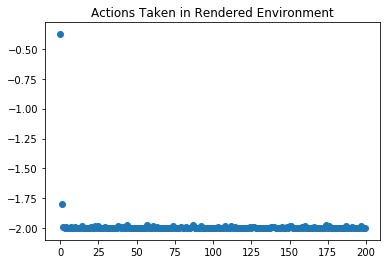

50
average reward:  -1597.4411042720524 stdevs: 0.010444598 losses: 236201.66
51
average reward:  -1602.7988844689694 stdevs: 0.010239523 losses: 209363.58
52
average reward:  -1611.375699990383 stdevs: 0.010210354 losses: 241639.34
53
average reward:  -1603.206692151948 stdevs: 0.010047964 losses: 245438.56
54
average reward:  -1601.2076315970326 stdevs: 0.010470121 losses: 225156.36
55
average reward:  -1605.9411235424823 stdevs: 0.009999999 losses: 222350.2
56
average reward:  -1592.3235144959847 stdevs: 0.009999999 losses: 243695.06
57
average reward:  -1605.480266339288 stdevs: 0.010261124 losses: 254391.33
58
average reward:  -1611.5855581697854 stdevs: 0.009999999 losses: 250098.8
59
average reward:  -1610.6228897193023 stdevs: 0.0100968 losses: 252172.77
Rewards from rendering: -1553.1782622416476


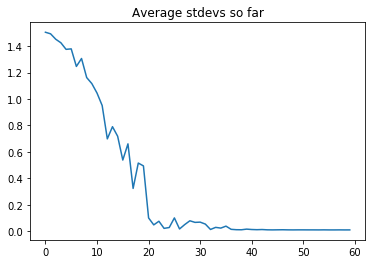

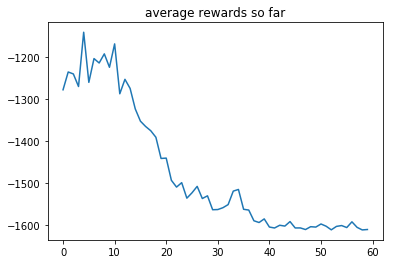

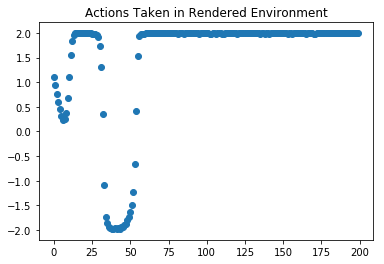

60
average reward:  -1605.200195591792 stdevs: 0.010080512 losses: 228206.31
61
average reward:  -1604.032558671249 stdevs: 0.010318921 losses: 217657.92
62
average reward:  -1602.2055021631909 stdevs: 0.009999999 losses: 247860.98
63
average reward:  -1605.7302420259311 stdevs: 0.009999999 losses: 246966.31
64
average reward:  -1590.1861349744681 stdevs: 0.010000982 losses: 158773.06
65
average reward:  -1584.8438521724165 stdevs: 0.010201254 losses: 236057.67
66
average reward:  -1554.914619577292 stdevs: 0.009999999 losses: 143508.25
67
average reward:  -1547.9128409177067 stdevs: 0.009999999 losses: 245824.31
68
average reward:  -1560.6963867233533 stdevs: 0.009999999 losses: 242140.17
69
average reward:  -1516.2238414290891 stdevs: 0.009999999 losses: 143188.7
Rewards from rendering: -1338.7653290393046


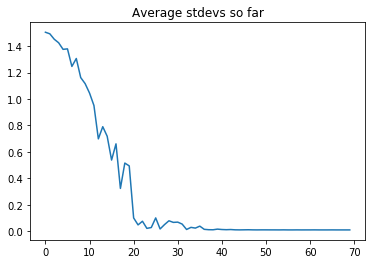

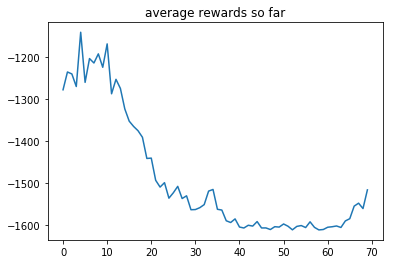

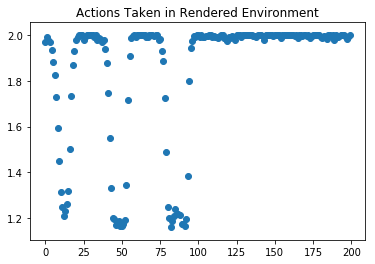

70
average reward:  -1539.3108214245678 stdevs: 0.009999999 losses: 203185.42
71
average reward:  -1459.323946824941 stdevs: 0.009999999 losses: 112558.445
72
average reward:  -1464.154154130739 stdevs: 0.009999999 losses: 240198.83
73
average reward:  -1410.9831291887062 stdevs: 0.009999999 losses: 206514.11
74
average reward:  -1454.979509840768 stdevs: 0.009999999 losses: 203626.6
75
average reward:  -1480.396881916322 stdevs: 0.009999999 losses: 145724.39
76
average reward:  -1416.8583882452874 stdevs: 0.009999999 losses: 127285.51
77
average reward:  -1457.9815275342096 stdevs: 0.009999999 losses: 145963.5
78
average reward:  -1425.8285038537515 stdevs: 0.009999999 losses: 170066.81
79
average reward:  -1397.133333419365 stdevs: 0.009999999 losses: 202057.4
Rewards from rendering: -1293.0519748965196


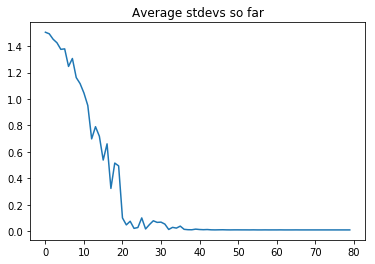

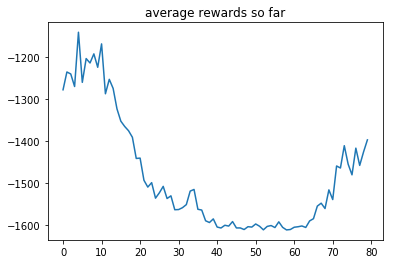

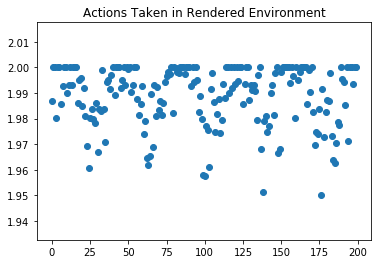

80
average reward:  -1467.7594496436882 stdevs: 0.009999999 losses: 229258.88
81
average reward:  -1412.753932163722 stdevs: 0.009999999 losses: 226043.81
82
average reward:  -1476.5463419033013 stdevs: 0.009999999 losses: 206537.84
83
average reward:  -1411.3223202755134 stdevs: 0.009999999 losses: 221311.1
84
average reward:  -1373.639309129116 stdevs: 0.009999999 losses: 161282.69
85
average reward:  -1396.9736064880199 stdevs: 0.010001211 losses: 213356.6
86
average reward:  -1426.664767794595 stdevs: 0.009999999 losses: 212316.56
87
average reward:  -1438.7676477721739 stdevs: 0.009999999 losses: 217998.86
88
average reward:  -1405.0718194188873 stdevs: 0.009999999 losses: 216867.6
89
average reward:  -1423.0112718667558 stdevs: 0.009999999 losses: 174095.53
Rewards from rendering: -1173.423854964122


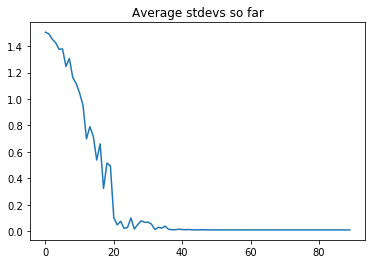

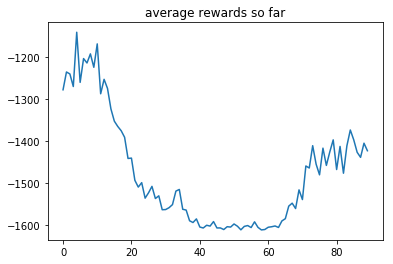

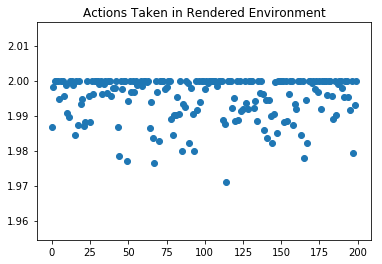

90
average reward:  -1453.2376164313814 stdevs: 0.009999999 losses: 193583.98
91
average reward:  -1457.3926428061825 stdevs: 0.009999999 losses: 196393.53
92
average reward:  -1443.5623575006157 stdevs: 0.009999999 losses: 191213.3
93
average reward:  -1401.7340947134749 stdevs: 0.009999999 losses: 136841.5
94
average reward:  -1437.838485378738 stdevs: 0.009999999 losses: 188357.62
95
average reward:  -1380.3932283846107 stdevs: 0.009999999 losses: 205609.45
96
average reward:  -1379.7120754478415 stdevs: 0.009999999 losses: 156643.47
97
average reward:  -1418.5874753359533 stdevs: 0.009999999 losses: 187690.02
98
average reward:  -1439.2693447833706 stdevs: 0.009999999 losses: 188640.34
99
average reward:  -1468.5165341109373 stdevs: 0.009999999 losses: 94323.305
Rewards from rendering: -939.0201176803429


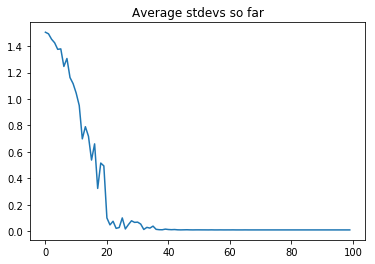

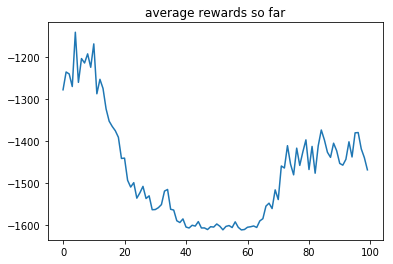

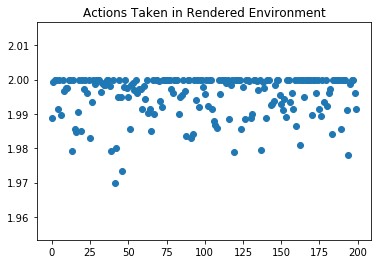

100
average reward:  -1427.6345302791049 stdevs: 0.009999999 losses: 198700.14
101
average reward:  -1419.3166566627008 stdevs: 0.009999999 losses: 90876.81
102
average reward:  -1473.6740828189402 stdevs: 0.009999999 losses: 180358.28
103
average reward:  -1433.9236678725626 stdevs: 0.009999999 losses: 109803.18
104
average reward:  -1446.9217953880295 stdevs: 0.009999999 losses: 191214.53
105
average reward:  -1402.162035592074 stdevs: 0.009999999 losses: 187384.3
106
average reward:  -1442.9484478073334 stdevs: 0.009999999 losses: 181089.9
107
average reward:  -1424.2335135200076 stdevs: 0.009999999 losses: 190331.89
108
average reward:  -1455.8882094224405 stdevs: 0.009999999 losses: 181732.38
109
average reward:  -1409.1292791121784 stdevs: 0.009999999 losses: 185635.86
Rewards from rendering: -1239.293661112774


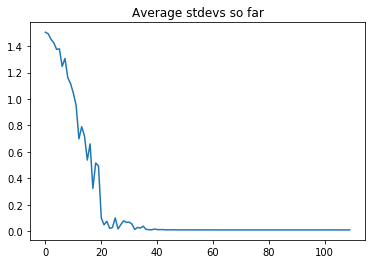

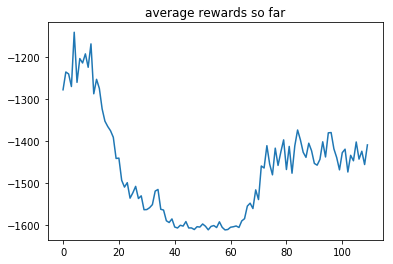

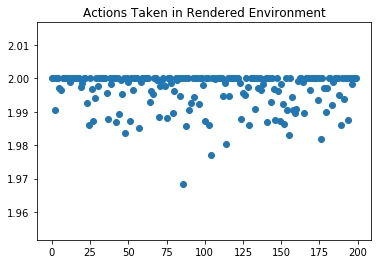

110
average reward:  -1376.8807032927068 stdevs: 0.009999999 losses: 64476.54
111
average reward:  -1431.535564042602 stdevs: 0.009999999 losses: 179364.5
112
average reward:  -1466.9932382287316 stdevs: 0.009999999 losses: 180026.61
113
average reward:  -1401.582043295094 stdevs: 0.009999999 losses: 179560.27
114
average reward:  -1422.2552582642 stdevs: 0.009999999 losses: 179414.67
115
average reward:  -1437.6876130963503 stdevs: 0.009999999 losses: 101977.31
116
average reward:  -1428.2173637921455 stdevs: 0.009999999 losses: 147462.11
117
average reward:  -1407.757081222239 stdevs: 0.009999999 losses: 61873.867
118
average reward:  -1414.234562195674 stdevs: 0.009999999 losses: 58307.93
119
average reward:  -1393.4665572143297 stdevs: 0.009999999 losses: 169028.05
Rewards from rendering: -1495.9895695714142


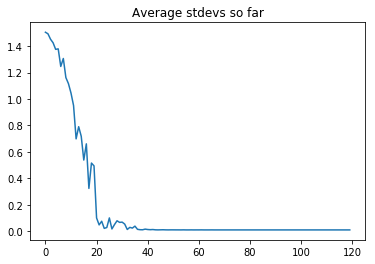

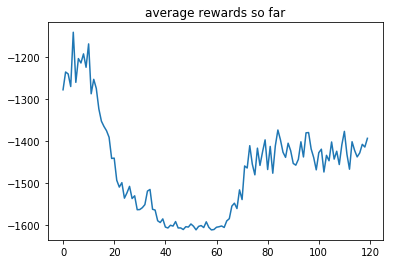

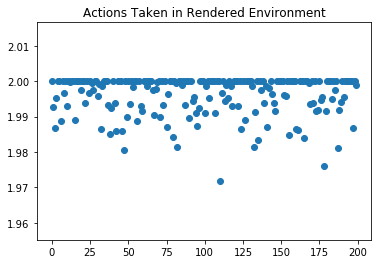

120
average reward:  -1444.1327560956927 stdevs: 0.009999999 losses: 168084.06
121
average reward:  -1453.129399602401 stdevs: 0.009999999 losses: 172591.1
122
average reward:  -1441.412195361389 stdevs: 0.009999999 losses: 162078.58
123
average reward:  -1433.6659105945823 stdevs: 0.009999999 losses: 162799.23
124
average reward:  -1419.9652832338852 stdevs: 0.009999999 losses: 162074.25
125
average reward:  -1470.8030114361627 stdevs: 0.009999999 losses: 162380.36
126
average reward:  -1363.3275353344748 stdevs: 0.009999999 losses: 158332.28
127
average reward:  -1396.224136303785 stdevs: 0.009999999 losses: 158054.25
128
average reward:  -1473.4947982463239 stdevs: 0.009999999 losses: 155902.8
129
average reward:  -1436.7028630515704 stdevs: 0.009999999 losses: 155662.81
Rewards from rendering: -1612.5779049846349


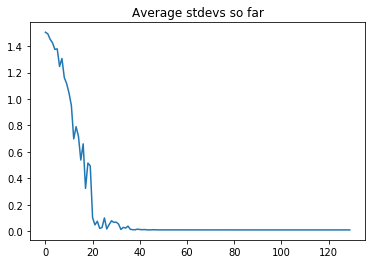

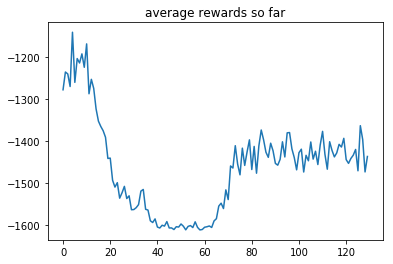

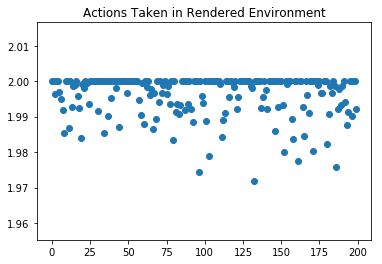

130
average reward:  -1400.914477551797 stdevs: 0.009999999 losses: 86657.87
131
average reward:  -1406.2297141260576 stdevs: 0.009999999 losses: 118919.95
132
average reward:  -1411.3040471384313 stdevs: 0.009999999 losses: 148518.67
133
average reward:  -1470.6265788329192 stdevs: 0.009999999 losses: 145702.88
134
average reward:  -1444.1309618254845 stdevs: 0.009999999 losses: 145858.77
135
average reward:  -1368.0450165257655 stdevs: 0.009999999 losses: 157159.17
136
average reward:  -1395.0910832136096 stdevs: 0.009999999 losses: 40018.41
137
average reward:  -1412.0040523863768 stdevs: 0.009999999 losses: 140069.05
138
average reward:  -1446.2071567682099 stdevs: 0.009999999 losses: 157466.39
139
average reward:  -1435.9778191980859 stdevs: 0.009999999 losses: 127910.79
Rewards from rendering: -1573.1502866661797


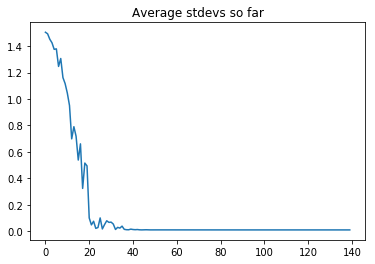

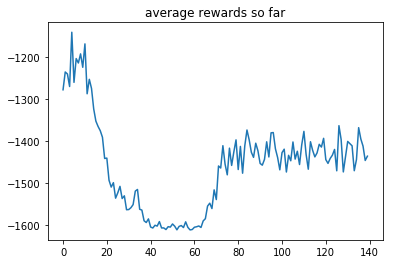

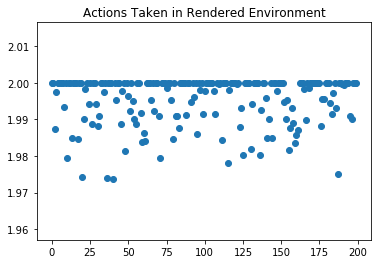

140
average reward:  -1483.400929387023 stdevs: 0.009999999 losses: 157568.34
141
average reward:  -1389.3467514288102 stdevs: 0.009999999 losses: 145600.64
142
average reward:  -1464.6380353409475 stdevs: 0.009999999 losses: 107643.16
143
average reward:  -1498.0210859950755 stdevs: 0.009999999 losses: 103403.28
144
average reward:  -1433.7217972721378 stdevs: 0.009999999 losses: 123489.53
145
average reward:  -1499.1761482260802 stdevs: 0.009999999 losses: 49425.83
146
average reward:  -1394.7704701218856 stdevs: 0.009999999 losses: 129968.41
147
average reward:  -1438.0246051927447 stdevs: 0.009999999 losses: 114322.27
148
average reward:  -1470.6582341916073 stdevs: 0.009999999 losses: 86192.84
149
average reward:  -1389.6533661628814 stdevs: 0.009999999 losses: 123439.875
Rewards from rendering: -1656.7148448567434


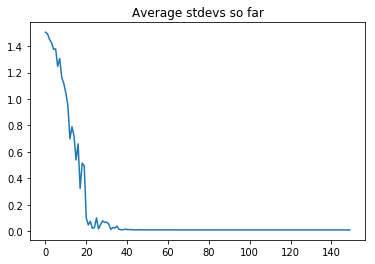

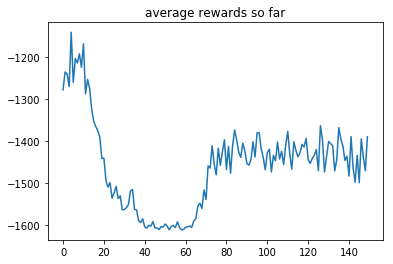

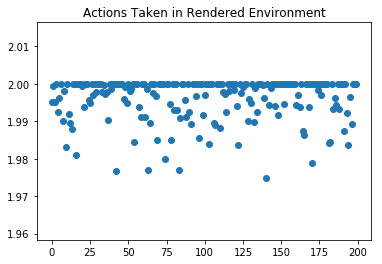

150
average reward:  -1417.3598371724004 stdevs: 0.009999999 losses: 123796.49
151
average reward:  -1422.3966494292638 stdevs: 0.009999999 losses: 146286.34
152
average reward:  -1443.339929292118 stdevs: 0.009999999 losses: 115718.13
153
average reward:  -1425.5679504953428 stdevs: 0.009999999 losses: 97256.875
154
average reward:  -1444.4058817096986 stdevs: 0.009999999 losses: 121625.414


In [ ]:
average_rewards = []
average_stdevs = []
for i in range(10000):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    if i % 10 == 0 and i > 0:
        
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")
        
        plottable_actions = renderAgent(pendulum, agent)
        plt.figure()
        plt.scatter(range(len(plottable_actions)), plottable_actions)
        plt.title("Actions Taken in Rendered Environment")
        plt.show()
        plt.close()
    for j in range(len(actions)):
        ret = prepSarData(actions[j], states[j], rewards[j])
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])
        states_pro.append(ret[0])
        #actions_pro.append((ret[1] - mean_reward)/stdev_reward)
        actions_pro.append(ret[1])
        rewards_pro.append(ret[2])
        #print(ret[0].shape, ret[1].shape, ret[2].shape)
        #for k in range(10):
        #    agent.trainSarBatches(ret[0], ret[1], ret[2])
    for k in range(5):
        train_index = np.random.choice(a=range(len(states_pro)))
        ret = agent.trainSarBatches(states_pro[train_index], actions_pro[train_index], rewards_pro[train_index])
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
pendulum.close()

In [ ]:
help(pendulum.close)

In [ ]:
help(tf.math.maximum)